In [1]:
import os
import pandas as pd 
import numpy as np 
import subprocess
import math
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import dataframe_image as dfi

import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
import matplotlib.cm 
import matplotlib.colors 
from matplotlib.gridspec import GridSpec
plt.rcParams['font.family'] = 'Arial'

from selenobot.files import FASTAFile, fasta_file_parser_gtdb, GBFFFile, BLASTFile
from selenobot.tools import BLAST
from selenobot.gene import Gene, Genome
from selenobot.organism import Organism
from selenobot.utils import apply_gtdb_dtypes

from selenobot.datasets import Dataset 

%load_ext autoreload 
%autoreload 2

# Make plots showing truncation ratios. 
# Look at stop codon frequency. 
# Try training using embeddings from only the last 20 amino acids or so -- intuition that these are more important for predicting, and removes the length constraint. 

# Mycobacterium is an intracellular parasite so might have a weird genome. 


In [2]:
species = ['Pseudomonas aeruginosa', 'Escherichia coli', 'Mycobacterium tuberculosis', 'Bacillus subtilis', 'Aliivibrio fischeri'] 

# Using the genomes from the GTDB species representative for release r207.
genome_ids = dict() 
genome_ids['Pseudomonas aeruginosa'] = 'GCF_001457615.1'
genome_ids['Bacillus subtilis'] = 'GCF_000009045.1'
genome_ids['Escherichia coli'] = 'GCF_000195955.2'
genome_ids['Mycobacterium tuberculosis'] = 'GCF_003697165.2'
genome_ids['Aliivibrio fischeri'] = 'GCF_016464335.1'

genome_metadata_df = pd.read_csv('../data/gtdb_genome_metadata_bacteria.csv', index_col=0)
genome_metadata_df = genome_metadata_df[genome_metadata_df.species.isin(species)]
genome_metadata_df[['species', 'genome_size', 'gc_percentage']]

label_map = {'cds':'cds', 'error':'error', 'inter':'error (intergenic)', 'pseudo':'pseudogene', 'rna':'other', 'misc':'other'}
color_map = {'cds':'tab:green', 'error':'tab:red', 'error (intergenic)':'tab:red', 'pseudogene':'tab:blue', 'other':'gray'}
labels = list(label_map.values())

feature_types = ['plm_esm_gap', 'plm_pt5']
pred_col = 'binary_model_plm_esm_gap_prediction'

In [ ]:
if (not os.path.exists('../data/model_organisms/organisms.pkl')):
    organisms = list()
    for species in genome_ids.keys():
        print(f'\n{species}')
        organism = Organism(genome_ids[species], species)
        organism.label()
        organisms.append(organism)
    with open('../data/model_organisms/organisms.pkl', 'wb') as f:
        pickle.dump(organisms, f)
else:
    with open('../data/model_organisms/organisms.pkl', 'rb') as f:
        organisms = pickle.load(f)


Pseudomonas aeruginosa


search: 100%|██████████| 5788/5788 [02:44<00:00, 35.29it/s]


Organism.label: Found 30 sequences in the input genome with the "inter" label.
Organism.label: Found 303 sequences in the input genome with the "error" label.
Organism.label: Found 77 sequences in the input genome with the "pseudo" label.
Organism.label: Found 5383 sequences in the input genome with the "cds" label.
Organism.label: Found 0 sequences in the input genome with the "rna" label.
Organism.label: Found 0 sequences in the input genome with the "misc" label.

Bacillus subtilis


search: 100%|██████████| 4226/4226 [01:39<00:00, 42.48it/s]


Organism.label: Found 34 sequences in the input genome with the "inter" label.
Organism.label: Found 233 sequences in the input genome with the "error" label.
Organism.label: Found 27 sequences in the input genome with the "pseudo" label.
Organism.label: Found 3938 sequences in the input genome with the "cds" label.
Organism.label: Found 0 sequences in the input genome with the "rna" label.
Organism.label: Found 27 sequences in the input genome with the "misc" label.

Escherichia coli


search: 100%|██████████| 4717/4717 [02:05<00:00, 37.49it/s]


Organism.label: Found 52 sequences in the input genome with the "inter" label.
Organism.label: Found 250 sequences in the input genome with the "error" label.
Organism.label: Found 60 sequences in the input genome with the "pseudo" label.
Organism.label: Found 4368 sequences in the input genome with the "cds" label.
Organism.label: Found 0 sequences in the input genome with the "rna" label.
Organism.label: Found 0 sequences in the input genome with the "misc" label.

Mycobacterium tuberculosis


In [ ]:
def load_organisms_df(labels:list=None, remove_partial:bool=True, max_seq_length:int=None):
    '''Load in data for all organisms, including the model predictions.'''

    df = pd.concat([organism.to_df() for organism in organisms])
    df.label = df.label.replace(label_map)
    df = df[df.label.isin(labels)] if (labels is not None) else df
    # NOTE: I think Prodigal only flags a sequence as "partial" if it runs off the end of a contig, so I think this is 
    # safe to filter... don't want to be trying to classify sequences we only have fragments of. 
    df = df[df.partial == '00'] if remove_partial else df # Really only care about the model's behavior on the complete genes. 
    df = df[df.seq.apply(len) < max_seq_length] if (max_seq_length is not None) else df

    pred_df = pd.concat([pd.read_csv(f'../data/results/gtdb_{organism.code_name}.predict.csv', index_col=0) for organism in organisms])
    pred_df = pred_df[[col for col in pred_df.columns if ('prediction' in col)]]

    df = df.merge(pred_df, left_index=True, right_index=True, how='left')
        
    return apply_gtdb_dtypes(df)

In [209]:
org_df = load_organisms_df()

In [ ]:
def table_1(path='../data/model_organisms/table_01.png'):   
    table_df = list()
    for organism in organisms:
        row = dict()
        row['species'] = organism.species
        row['GC content'] = organism.species
        row['ref. genome size'] = organism.size(source='ncbi', pseudo=False)
        row['GTDB genome size'] = organism.size(source='gtdb')
        row['num. pseudogenes'] = organism.size(source='ncbi', pseudo=True)
        row['perc. exact matches'] = f'{100 * len(organism.to_df(label='match')) / organism.size(source='gtdb'):.2f}%'
        table_df.append(row)
    table_df = pd.DataFrame(table_df).set_index('species')
    dfi.export(table_df, path)

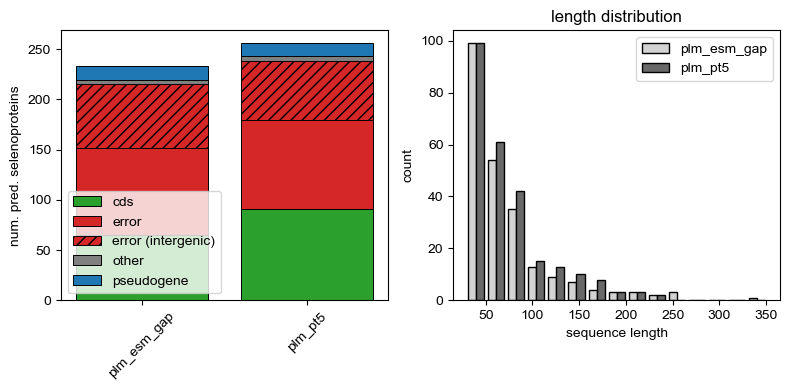

In [210]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

ax = axes[0]
bottom = np.zeros(len(feature_types))
positions = np.arange(len(feature_types))

legend = []
for label, label_df in org_df.groupby('label'):
    heights = [(label_df[f'binary_model_{feature_type}_prediction'] == 1).sum() for feature_type in feature_types]
    ax.bar(positions, heights, bottom=bottom, color=color_map[label], hatch='///' if (label == 'error (intergenic)') else None, edgecolor='black', lw=0.7)
    bottom += np.array(heights)
    legend += [label]

ax.set_xticks(positions, labels=feature_types, ha='center', rotation=45)
ax.set_ylabel('num. pred. selenoproteins')
ax.legend(legend)

ax = axes[1]
hist = []
for feature_type in feature_types:
    lengths = org_df[org_df[f'binary_model_{feature_type}_prediction'] == 1].seq.apply(len)
    hist.append(lengths)
    
ax.hist(hist, bins=15, color=['lightgrey', 'dimgray'], edgecolor='black', lw=0.5)
ax.legend(feature_types)
ax.set_ylabel('count')
ax.set_xlabel('sequence length')
ax.set_title('length distribution')

plt.tight_layout()
plt.show()

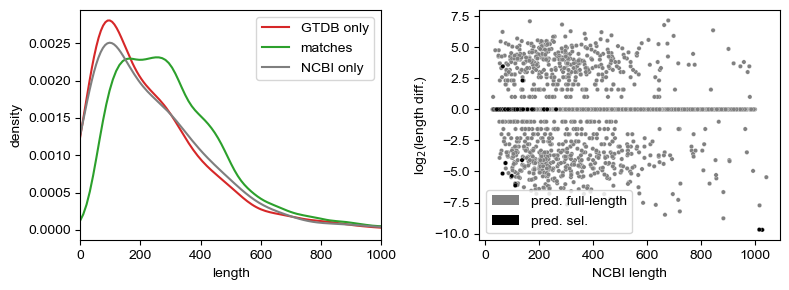

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))

ax = axes[0]

gtdb_df = load_organisms_df(labels=['error', 'error (intergenic)', 'pseudogene', 'other'])
shared_df = pd.concat([organism.to_df(label='cds') for organism in organisms])
ncbi_df = pd.concat([FASTAFile(organism.ncbi_proteins_path).to_df() for organism in organisms])
ncbi_df = ncbi_df[~ncbi_df.index.isin(shared_df.protein_id)]

gtdb_df.seq.apply(len).plot.kde(ax=ax, color='tab:red')
shared_df.ref_seq.apply(len).plot.kde(ax=ax, color='tab:green')
ncbi_df.seq.apply(len).plot.kde(ax=ax, color='tab:gray')
ax.set_xlim(0, 1000)
ax.set_ylabel('density')
ax.set_xlabel('length')
ax.legend(['GTDB only', 'matches', 'NCBI only'])

ax = axes[1]

shared_df = shared_df.merge(pred_df, left_index=True, right_index=True, how='inner')
shared_df = shared_df.sort_values('binary_model_plm_esm_gap_prediction')

# diffs = np.sign(shared_df.length_diff) * np.log(np.abs(shared_df.length_diff // 3) + 1)
# diffs = shared_df.length_diff // 3
# shared_df = shared_df[shared_df.length_diff != 0]
diffs = [0 if (d == 0) else np.sign(d) * np.log2(abs(d)) for d in shared_df.length_diff // 3]
lengths = np.log10(shared_df.ref_seq.apply(len))
lengths = shared_df.ref_seq.apply(len) 

ax.scatter(lengths, diffs, c=shared_df.binary_model_plm_esm_gap_prediction.replace({1:'black', 0:'gray'}), lw=0.2, s=10, edgecolors='white') 
ax.set_ylabel('log$_{2}$(length diff.)')
ax.set_xlabel('NCBI length')
ax.legend(handles=[Patch(facecolor='gray'), Patch(facecolor='black')], labels=['pred. full-length', 'pred. sel.'])
# ax.set_ylim(-1500, 500)

plt.tight_layout()
plt.show()



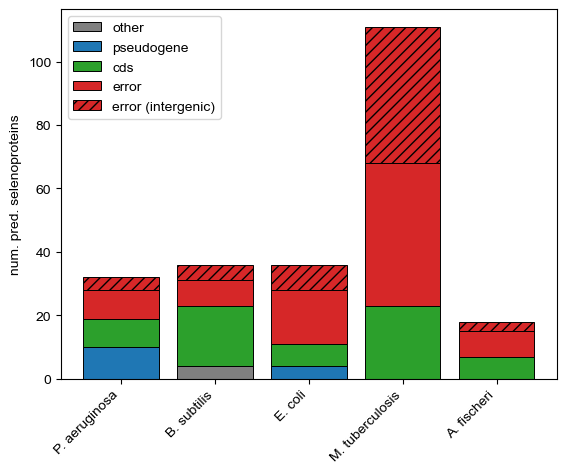

In [212]:
fig, ax = plt.subplots()

species = list(genome_ids.keys()) 

bottom = np.zeros(len(species))
for label in ['other', 'pseudogene', 'cds', 'error', 'error (intergenic)']:
    label_df = org_df[(org_df.label == label) & (org_df[pred_col] == 1)]
    # label_df = pd.concat([organism.to_df(label=label) for organism in organisms])
    heights = np.array([(label_df.species == s).sum() for s in species])
    ax.bar(np.arange(len(organisms)), heights, bottom=bottom, color=color_map[label], edgecolor='black', linewidth=0.7, hatch='///' if (label == 'error (intergenic)') else None)
    bottom += heights

ax.set_xticks(np.arange(len(organisms)), labels=[f'{organism.species.split()[0][0]}. {organism.species.split()[-1]}' for organism in organisms], rotation=45, ha='right')
ax.legend(['other', 'pseudogene', 'cds', 'error', 'error (intergenic)'])
# ax.set_yscale('log')
ax.set_ylabel('num. pred. selenoproteins')
plt.show()




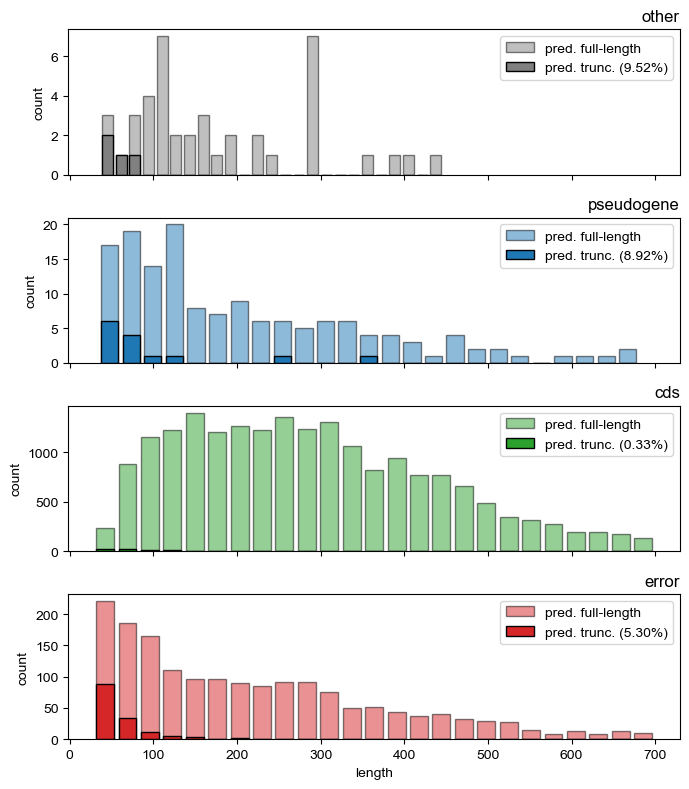

In [ ]:
fig, axes = plt.subplots(nrows=4, figsize=(7, 8), sharex=True)

def figure_4(org_df:pd.DataFrame, max_seq_length:int=700, axes:list=None):

    org_df.label = pred_df.label.replace({'error (intergenic)':'error'})
    org_sec_df = org_df[org_df[pred_col] == 1]

    for ax, label in zip(axes, ['other', 'pseudogene', 'cds', 'error']):
        lengths = org_df[org_df.label == label].seq.apply(len)
        _, bin_edges, _, = ax.hist(lengths[lengths < max_seq_length], color=color_map[label], bins=25, rwidth=0.8, edgecolor='black', alpha=0.5)
        p = f'{100 * len(pred_sec_df[pred_sec_df.label == label]) / len(lengths):.2f}%'

        lengths = org_sec_df[org_sec_df.label == label].seq.apply(len) # Look only at the lengths of the predicted selenoproteins. 
        ax.hist(lengths[lengths < max_seq_length], color=color_map[label], bins=bin_edges, rwidth=0.8, edgecolor='black')

        ax.set_ylabel('count')
        ax.set_title(label, loc='right')
        ax.legend(['pred. full-length', f'pred. trunc. ({p})'])

    ax.set_xlabel('length')

figure_4(org_df, axes=axes)

plt.tight_layout()
plt.show()

# I am really curious as to why so many of the short peptides are tagged as full-length... what characteristics of the
# false positives make them false positives, other than length? It seems as though the error sequences are slightly 
# more prone to this problem, though I wonder how much of this effect is due to the fact that the error sequences tend 
# to be shorter. 

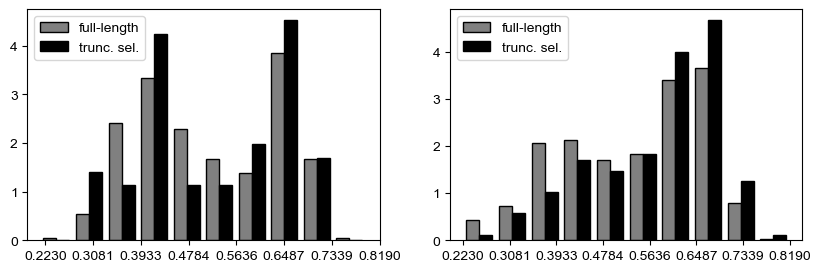

In [238]:
# First going to take a look at the spurious short sequences... what causes them to be flagged?
org_err_df = load_organisms_df(labels=['error', 'error (intergenic)'], max_seq_length=200)
org_cds_df = load_organisms_df(labels=['cds'], max_seq_length=200)


# Maybe has to do with GC content?
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

for ax, df in zip(axes, [org_cds_df, org_err_df]):
    hists = [df_.gc_content for _, df_ in df.groupby(pred_col)]
    ax.hist(hists, density=True, color=['gray', 'black'], edgecolor='black', lw=0.7)
    ax.legend(['full-length', 'trunc. sel.'])
    ax.set_xticks(np.linspace(org_error_df.gc_content.min(), org_error_df.gc_content.max(), 8))
plt.show()

# Doesn't seem to be any real difference in GC content...

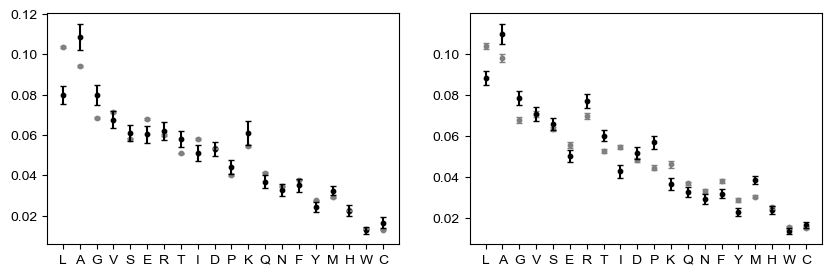

In [ ]:
# Differences in GC content could signal differences in amino acid composition?
amino_acids = list('LAGVSERTIDPKQNFYMHWC')
x = np.arange(len(amino_acids))

fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

kwargs = {'capsize':2, 'fmt':'none'}
color_map[0] = 'gray'
color_map[1] = 'black'

for ax, df in zip(axes, [org_cds_df, org_err_df]):

    for pred, df_ in df.groupby(pred_col):
        aa_comps_df = pd.DataFrame([{aa:seq.count(aa) / len(seq) for aa in amino_acids} for seq in df_.seq])
        ax.errorbar(x, aa_comps_df.mean(axis=0), yerr=aa_comps_df.std(axis=0) / np.sqrt(len(aa_comps_df)), c=color_map[pred], **kwargs)
        ax.scatter(x, aa_comps_df.mean(axis=0), c=color_map[pred], s=10)
    ax.set_xticks(x, labels=amino_acids)

plt.show()




In [ ]:
# Another thing to try is to BLAST align the positive predictions with the truncated selenoproteins. 

subj_fasta_file = FASTAFile('blast_subject.fa') # All truncated selenoproteins in the training, testing, and validation datasets.
quer_fasta_file = FASTAFile('blast_query.fa') # All model organism sequences shorter than 200 amino acids in length. 
print('Number of query sequences:', len(quer_fasta_file))
print('Number of subject sequences:', len(subj_fasta_file))

# blast = BLAST()
# blast.run('blast_query.fa', 'blast_subject.fa', output_path='blast_output.tsv', make_database=False, max_high_scoring_pairs=1)

Number of query sequences: 7539
Number of subject sequences: 5810


In [365]:
org_df = load_organisms_df(max_seq_length=200)
blast_df = BLASTFile('blast_output.tsv').to_df()

blast_n_hits = blast_df[blast_df.e_value < 1e-4].groupby('query_id').apply(len, include_groups=False)
outliers = blast_n_hits.sort_values(ascending=False)[blast_n_hits > 499].index 

# org_df[org_df.index.isin(outliers)][pred_col]


BLASTFile.load_chunks: Loading BLAST output in batches...: 100%|██████████| 151/151 [00:00<00:00, 410.03it/s]


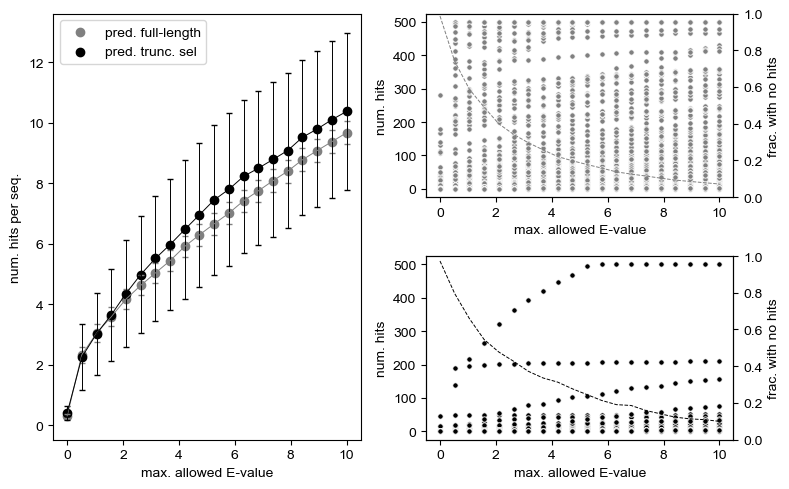

In [ ]:
fig = plt.figure(layout='tight', figsize=(8, 5))
grid = GridSpec(nrows=2, ncols=2, figure=fig)

ax_1a = fig.add_subplot(grid[:, 0])
ax_1b = [fig.add_subplot(grid[0, 1]), fig.add_subplot(grid[1, 1])]

# Remove the outliers... 
org_df = org_df[~org_df.index.isin(outliers)]

for pred, df in org_df.groupby(pred_col):
    x, y, y_err = list(), list(), list()
    for e in np.linspace(1e-4, blast_df.e_value.max(), 20):
        blast_n_hits = blast_df[blast_df.e_value < e].groupby('query_id').apply(len, include_groups=False)
        blast_n_hits.name = 'blast_n_hits'
        e_df = df.merge(blast_n_hits, left_index=True, right_index=True, how='left')
        e_df.blast_n_hits = e_df.blast_n_hits.fillna(0)

        y.append(e_df.blast_n_hits.mean())
        y_err.append(e_df.blast_n_hits.std() / np.sqrt(len(e_df)))
        x.append(e)

    ax_1a.scatter(x, y, c=color_map[pred])
    ax_1a.errorbar(x, y, yerr=y_err, c=color_map[pred], capsize=2, lw=0.7)

ax_1a.legend(['pred. full-length', 'pred. trunc. sel'])
ax_1a.set_xlabel('max. allowed E-value')
ax_1a.set_ylabel('num. hits per seq.')

for ax, (pred, df) in zip(ax_1b, org_df.groupby(pred_col)):
    x1, y1, x2, y2 = list(), list(), list(), list()
    for e in np.linspace(1e-4, blast_df.e_value.max(), 20):
        blast_n_hits = blast_df[blast_df.e_value < e].groupby('query_id').apply(len, include_groups=False)
        blast_n_hits.name = 'blast_n_hits'
        e_df = df.merge(blast_n_hits, left_index=True, right_index=True, how='left')
        e_df.blast_n_hits = e_df.blast_n_hits.fillna(0)

        x1 += [e] * len(e_df)
        y1 += e_df.blast_n_hits.values.tolist()
        x2 += [e]
        y2 += [(e_df.blast_n_hits == 0).sum() / len(e_df)]

    ax.scatter(x1, y1, s=15, edgecolors='white', lw=0.6, c=color_map[pred])
    ax.set_ylabel('num. hits')
    ax.set_xlabel('max. allowed E-value')

    right_ax = ax.twinx()
    right_ax.plot(x2, y2, color=color_map[pred], lw=0.7, ls='--')
    right_ax.set_ylabel('frac. with no hits')
    right_ax.set_ylim(0, 1)

plt.show()



